In [676]:
# Data handling
import numpy as np
import pandas as pd
import re

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import graphviz
import optuna
import optuna.visualization as vis
%matplotlib inline

# Stats
from statsmodels.graphics.gofplots import qqplot
import statsmodels.api as sm
import scipy.stats as st
from scipy.stats import shapiro, norm, chi2_contingency, kstest, boxcox

# Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder,PowerTransformer
from sklearn.compose import ColumnTransformer

# Models
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor,KNeighborsClassifier
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor,AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor, export_graphviz

# Metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error

#lib
from lib.clean_data_functions import clean_ext_version, clean_ext_publisher, clean_repo_publisher

#
from wordcloud import WordCloud,STOPWORDS
from ast import literal_eval
from collections import Counter

# os
import os

import pickle

# time
import time

import warnings
# warnings.filterwarnings("ignore")    # (Optional)

print("Project has been created with Pandas: " ,pd. __version__," And with Numpy: ",np. __version__)

Project has been created with Pandas:  2.3.1  And with Numpy:  2.3.2


### Loading

In [677]:
import yaml

try:
    with open("../config.yaml", "r") as file:
        config = yaml.safe_load(file)
except:
    print("Yaml configuration file not found!")

In [678]:
config

{'data': {'raw': {'file_scraped': '../data/raw/vscode_extensions_scraped_0825.csv',
   'file_verified': '../data/raw/VSCode Extensions_Verified.csv',
   'file_vulnerable': '../data/raw/VSCode Extensions_Vulnerabilities.csv',
   'file_ext_repo': '../data/raw/extensions_repos_full.csv'},
  'clean': {'file_scrap_cleaned': '../data/clean/extensions_scrap_cleaned.csv',
   'file_data_cleaned': '../data/clean/extensions_data_cleaned.csv',
   'file_eda_cleaned': '../data/clean/extensions_eda_cleaned.csv'}},
 'model': {'preprocessing': {'file_ohe': '../model/one_hot_encoder.pkl'}}}

In [679]:
df = pd.read_csv(config["data"]["clean"]["file_eda_cleaned"])
# df = df.sort_values(by = ["ext_install_count", "ext_rating"], ascending= False)
df.head()

,ext_categories,ext_install_count,verified,total_vulners,high_vulners,medium_vulners,low_vulners,repo_stars,repo_forks,repo_languages,ext_rating_category,ext_version_category
0,Programming Languages,2174,True,0,0,0,0,3,1,typescript,2,2
1,Programming Languages,2174,True,0,0,0,0,3,1,python,2,2
2,Programming Languages,2174,True,0,0,0,0,3,1,javascript,2,2
3,Programming Languages,2174,True,0,0,0,0,3,1,jupyter notebook,2,2
4,Programming Languages,2174,True,0,0,0,0,4461,1,shell,2,2


### 5. Preprocessing 

In [680]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37929 entries, 0 to 37928
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ext_categories        37929 non-null  object
 1   ext_install_count     37929 non-null  int64 
 2   verified              37929 non-null  bool  
 3   total_vulners         37929 non-null  int64 
 4   high_vulners          37929 non-null  int64 
 5   medium_vulners        37929 non-null  int64 
 6   low_vulners           37929 non-null  int64 
 7   repo_stars            37929 non-null  int64 
 8   repo_forks            37929 non-null  int64 
 9   repo_languages        37929 non-null  object
 10  ext_rating_category   37929 non-null  int64 
 11  ext_version_category  37929 non-null  int64 
dtypes: bool(1), int64(9), object(2)
memory usage: 3.2+ MB


- Handle duplicated

In [681]:
df.duplicated().sum()

np.int64(1305)

In [682]:
df = df.drop_duplicates()
df

,ext_categories,ext_install_count,verified,total_vulners,high_vulners,medium_vulners,low_vulners,repo_stars,repo_forks,repo_languages,ext_rating_category,ext_version_category
0,Programming Languages,2174,True,0,0,0,0,3,1,typescript,2,2
1,Programming Languages,2174,True,0,0,0,0,3,1,python,2,2
2,Programming Languages,2174,True,0,0,0,0,3,1,javascript,2,2
3,Programming Languages,2174,True,0,0,0,0,3,1,jupyter notebook,2,2
4,Programming Languages,2174,True,0,0,0,0,4461,1,shell,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...
37924,Other,3,False,0,0,0,0,42,6,javascript,0,0
37925,Other,3,False,0,0,0,0,42,6,shell,0,0
37926,Other,2,False,0,0,0,0,1,1,typescript,0,0
37927,Other,1,True,1,1,0,0,3,0,typescript,0,0


- Handle missing values

In [683]:
df.isna().sum()

ext_categories          0
ext_install_count       0
verified                0
total_vulners           0
high_vulners            0
medium_vulners          0
low_vulners             0
repo_stars              0
repo_forks              0
repo_languages          0
ext_rating_category     0
ext_version_category    0
dtype: int64

- Feature transformation/Transform values

Handle categories with high cardinality -> Grouping rare

In [684]:
df["ext_categories"].value_counts(normalize=True)

ext_categories
Other                    0.351982
Programming Languages    0.185780
Themes                   0.131116
Snippets                 0.111184
Formatters               0.048247
Linters                  0.038554
Debuggers                0.032383
Extension Packs          0.022499
Visualization            0.020151
Testing                  0.010676
Data Science             0.007754
Education                0.006635
Machine Learning         0.006362
Keymaps                  0.006198
Notebooks                0.005188
Azure                    0.004833
Language Packs           0.004806
SCM Providers            0.004178
AI                       0.000846
Chat                     0.000628
Name: proportion, dtype: float64

In [685]:
df["repo_languages"].value_counts(normalize=True)

repo_languages
typescript       0.312200
javascript       0.220047
unknown          0.165438
css              0.047018
html             0.039018
                   ...   
kaitai struct    0.000027
crystal          0.000027
cap'n proto      0.000027
q#               0.000027
qt script        0.000027
Name: proportion, Length: 266, dtype: float64

In [686]:
threshold_ext_categories = 0.1  # e.g., categories below 10% frequency
value_counts_ext_categories = df["ext_categories"].value_counts(normalize=True)
rare_categories = value_counts_ext_categories[value_counts_ext_categories.values <= threshold_ext_categories].index

def transform_ext_categories(x):
    text = str(x)
    if text == "Other":
        return "Unknown"
    elif text in rare_categories:
        return "Others"
    else:
        return x
df["ext_categories_grouped"] = df["ext_categories"].apply(transform_ext_categories)

In [687]:
threshold_repo_languages = 0.05 # e.g., categories below 3% frequency
value_counts_repo_languages = df["repo_languages"].value_counts(normalize=True)
rare_categories = value_counts_repo_languages[value_counts_repo_languages.values <= threshold_repo_languages].index

def transform_repo_languages(x):
    text = str(x)
    if text  in ["other", "unknown"]:
        return "unknown"
    elif text in rare_categories:
        return "others"
    else:
        return x
df["repo_languages_grouped"] = df["repo_languages"].apply(transform_repo_languages)

In [688]:
# threshold_ext_categories = 0.1  # e.g., categories below 10% frequency
# value_counts_ext_categories = df['ext_categories'].value_counts(normalize=True)
# rare_categories = value_counts_ext_categories[value_counts_ext_categories.values <= threshold_ext_categories].index
# df['ext_categories_grouped'] = df['ext_categories'].apply(lambda x: 'Rest' if x in rare_categories else x)


In [689]:
# threshold_repo_languages = 0.03  # e.g., categories below 3% frequency
# value_counts_repo_languages = df["repo_languages"].value_counts(normalize=True)
# rare_categories = value_counts_repo_languages[value_counts_repo_languages.values <= threshold_repo_languages].index
# df["repo_languages_grouped"] = df["repo_languages"].apply(lambda x: 'rest' if x in rare_categories else x)

In [690]:
df["ext_categories_grouped"].value_counts(normalize=True)

ext_categories_grouped
Unknown                  0.351982
Others                   0.219938
Programming Languages    0.185780
Themes                   0.131116
Snippets                 0.111184
Name: proportion, dtype: float64

In [691]:
df["repo_languages_grouped"].value_counts(normalize=True)

repo_languages_grouped
typescript    0.312200
others        0.271898
javascript    0.220047
unknown       0.195855
Name: proportion, dtype: float64

In [692]:
df = df.drop(columns=["repo_languages", "ext_categories"])
df

,ext_install_count,verified,total_vulners,high_vulners,medium_vulners,low_vulners,repo_stars,repo_forks,ext_rating_category,ext_version_category,ext_categories_grouped,repo_languages_grouped
0,2174,True,0,0,0,0,3,1,2,2,Programming Languages,typescript
1,2174,True,0,0,0,0,3,1,2,2,Programming Languages,others
2,2174,True,0,0,0,0,3,1,2,2,Programming Languages,javascript
3,2174,True,0,0,0,0,3,1,2,2,Programming Languages,others
4,2174,True,0,0,0,0,4461,1,2,2,Programming Languages,others
...,...,...,...,...,...,...,...,...,...,...,...,...
37924,3,False,0,0,0,0,42,6,0,0,Unknown,javascript
37925,3,False,0,0,0,0,42,6,0,0,Unknown,others
37926,2,False,0,0,0,0,1,1,0,0,Unknown,typescript
37927,1,True,1,1,0,0,3,0,0,0,Unknown,typescript


- Convert target to number

In [693]:
df["verified"] = df["verified"].map({True: 1, False:0})

- Get number and category columns

In [694]:
potential_categorical_from_numerical = df.select_dtypes("number").loc[:, df.select_dtypes("number").nunique() < 10].drop(columns="verified")
potential_categorical_from_numerical

,ext_rating_category,ext_version_category
0,2,2
1,2,2
2,2,2
3,2,2
4,2,2
...,...,...
37924,0,0
37925,0,0
37926,0,0
37927,0,0


In [695]:

df_categorical = pd.concat([df.select_dtypes("object"), potential_categorical_from_numerical], axis=1)
df_numerical = df.select_dtypes("number").drop(columns=potential_categorical_from_numerical.columns)

In [696]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36624 entries, 0 to 37928
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   ext_install_count       36624 non-null  int64 
 1   verified                36624 non-null  int64 
 2   total_vulners           36624 non-null  int64 
 3   high_vulners            36624 non-null  int64 
 4   medium_vulners          36624 non-null  int64 
 5   low_vulners             36624 non-null  int64 
 6   repo_stars              36624 non-null  int64 
 7   repo_forks              36624 non-null  int64 
 8   ext_rating_category     36624 non-null  int64 
 9   ext_version_category    36624 non-null  int64 
 10  ext_categories_grouped  36624 non-null  object
 11  repo_languages_grouped  36624 non-null  object
dtypes: int64(10), object(2)
memory usage: 3.6+ MB


In [697]:
cols_num = df_numerical.columns.to_list()

In [698]:
cols_num = df_numerical.drop("verified",axis=1).columns.to_list()
# cols_num = df_numerical.columns.to_list()
cols_cat = df_categorical.columns.to_list()
cols_num, cols_cat

(['ext_install_count',
  'total_vulners',
  'high_vulners',
  'medium_vulners',
  'low_vulners',
  'repo_stars',
  'repo_forks'],
 ['ext_categories_grouped',
  'repo_languages_grouped',
  'ext_rating_category',
  'ext_version_category'])

#### Spliting Test data

In [699]:
features = df.drop(columns = ["verified"])
target = df["verified"]
X_train, X_test, y_train, y_test = train_test_split(features,target, test_size = 0.20, random_state=0) #before transforming

In [700]:
X_train.shape, X_test.shape

((29299, 11), (7325, 11))

In [701]:
df

,ext_install_count,verified,total_vulners,high_vulners,medium_vulners,low_vulners,repo_stars,repo_forks,ext_rating_category,ext_version_category,ext_categories_grouped,repo_languages_grouped
0,2174,1,0,0,0,0,3,1,2,2,Programming Languages,typescript
1,2174,1,0,0,0,0,3,1,2,2,Programming Languages,others
2,2174,1,0,0,0,0,3,1,2,2,Programming Languages,javascript
3,2174,1,0,0,0,0,3,1,2,2,Programming Languages,others
4,2174,1,0,0,0,0,4461,1,2,2,Programming Languages,others
...,...,...,...,...,...,...,...,...,...,...,...,...
37924,3,0,0,0,0,0,42,6,0,0,Unknown,javascript
37925,3,0,0,0,0,0,42,6,0,0,Unknown,others
37926,2,0,0,0,0,0,1,1,0,0,Unknown,typescript
37927,1,1,1,1,0,0,3,0,0,0,Unknown,typescript


### Feature Engineering

OHE: for nominal categorial

In [702]:
ohe = OneHotEncoder(sparse_output=False)
ohe.fit((X_train[["repo_languages_grouped", "ext_categories_grouped"]]))
X_train_trans_nom_np = ohe.transform(X_train[["repo_languages_grouped", "ext_categories_grouped"]])
X_test_trans_nom_np = ohe.transform(X_test[["repo_languages_grouped", "ext_categories_grouped"]])

X_train_nom_trans_df = pd.DataFrame(X_train_trans_nom_np, columns=ohe.get_feature_names_out(), index=X_train.index)
X_test_nom_trans_df = pd.DataFrame(X_test_trans_nom_np, columns=ohe.get_feature_names_out(), index=X_test.index)

In [703]:
X_train_nom_trans_df

,repo_languages_grouped_javascript,repo_languages_grouped_others,repo_languages_grouped_typescript,repo_languages_grouped_unknown,ext_categories_grouped_Others,ext_categories_grouped_Programming Languages,ext_categories_grouped_Snippets,ext_categories_grouped_Themes,ext_categories_grouped_Unknown
27712,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
36390,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
30158,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2072,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
37222,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
20904,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
32609,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
30782,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
21392,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [704]:
with open(config["model"]["preprocessing"]["file_ohe"], "wb") as file:
    pickle.dump(ohe, file)

Transform cols_num to normal distribution

C:\Users\Gast\AppData\Local\Temp\ipykernel_9632\655375652.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


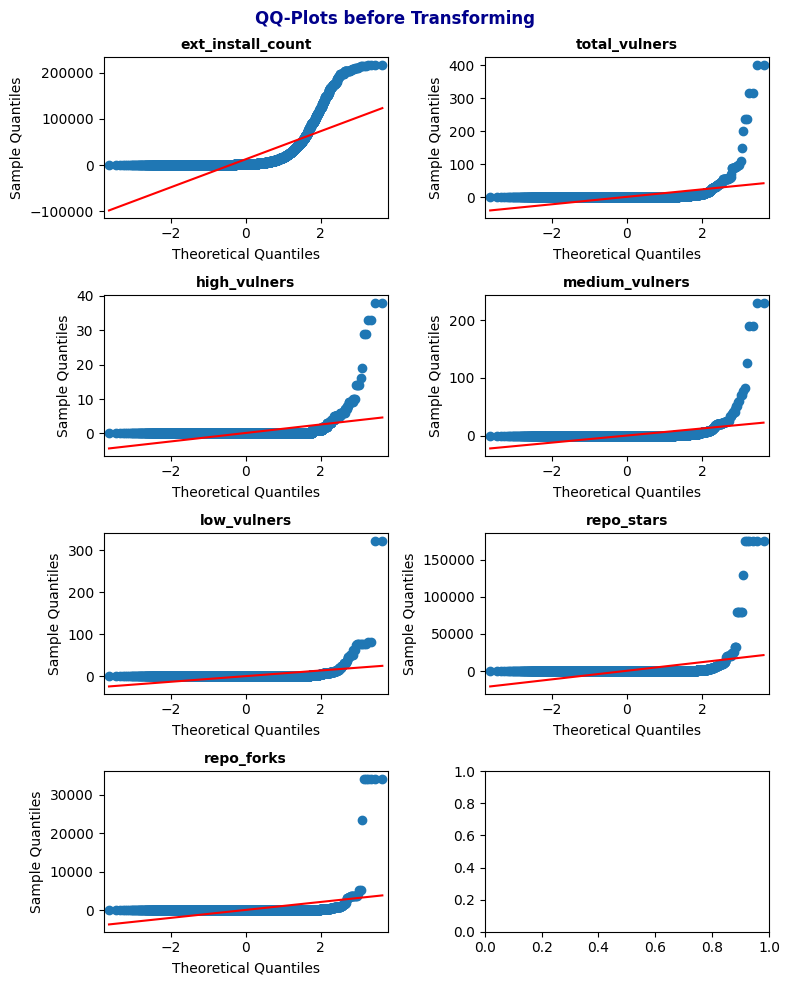

In [705]:
fig, axes = plt.subplots(nrows = int(np.ceil(len(cols_num)/2)), ncols = 2, figsize = (8,10))
axes = axes.flat

for i,col in enumerate(cols_num):
    sm.qqplot(X_test[col], 
           line = "s", 
           ax = axes[i])
    
    axes[i].set_title(col, fontsize = 10, fontweight = "bold", color = "black")
    
# fig.delaxes(axes[7])
fig.suptitle("QQ-Plots before Transforming", fontsize = 12, fontweight = "bold", color = "darkblue")
fig.tight_layout()
fig.show()

Powertransform

In [706]:
# Power transform
pt = PowerTransformer(method="yeo-johnson")

X_train_num = X_train[cols_num]
pt.fit(X_train_num)
X_test_num  = X_test[cols_num]

X_train_num_trans = pt.transform(X_train_num)
X_test_num_trans = pt.transform(X_test_num)

X_train_num_trans_df = pd.DataFrame(X_train_num_trans, columns=X_train_num.columns, index=X_train_num.index )
X_test_num_trans_df = pd.DataFrame(X_test_num_trans, columns=X_test_num.columns, index=X_test_num.index )

Normalize transform

In [707]:
# #Normalizer
# normalizer = MinMaxScaler()
# X_train_num = X_train[cols_num]
# normalizer.fit(X_train_num)
# X_test_num  = X_test[cols_num]

# X_train_trans = normalizer.transform(X_train_num)
# X_test_trans = normalizer.transform(X_test_num)

# X_train_trans = pd.DataFrame(X_train_trans, columns=X_train_num.columns, index=X_train_num.index)
# X_test_trans = pd.DataFrame(X_test_trans, columns=X_test_num.columns, index=X_test_num.index)

Log Transform

In [708]:
# #Log-transform
# for col in cols_num:
#     df[col] = np.log1p(df[col])
    # X_train_trans = pt.transform(X_train_num)
    # X_test_trans = pt.transform(X_test_num)

C:\Users\Gast\AppData\Local\Temp\ipykernel_9632\721971173.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


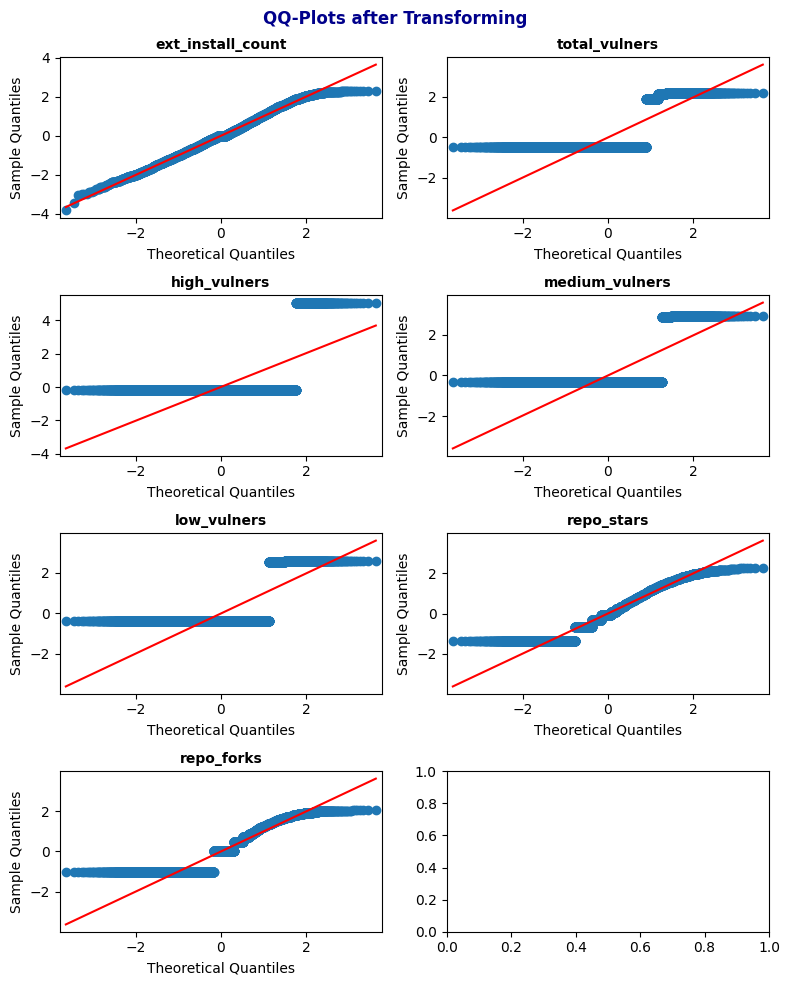

In [709]:
fig, axes = plt.subplots(nrows = int(np.ceil(len(cols_num)/2)), ncols = 2, figsize = (8,10))
axes = axes.flat

for i,col in enumerate(cols_num):
    sm.qqplot(X_test_num_trans_df[col], 
           line = "s", 
           ax = axes[i]);
    
    axes[i].set_title(col, fontsize = 10, fontweight = "bold", color = "black")
    
# fig.delaxes(axes[7])
fig.suptitle("QQ-Plots after Transforming", fontsize = 12, fontweight = "bold", color = "darkblue")
fig.tight_layout()
fig.show()


Combining

In [710]:
X_train_ord_trans_df = X_train[["ext_rating_category","ext_version_category"]].copy()
X_test_ord_trans_df = X_test[["ext_rating_category","ext_version_category"]].copy()

In [711]:
X_train_trans = pd.concat([X_train_num_trans_df, X_train_nom_trans_df, X_train_ord_trans_df], axis=1)
X_test_trans = pd.concat([X_test_num_trans_df, X_test_nom_trans_df, X_test_ord_trans_df], axis=1)   


In [712]:
X_trans =  pd.concat([X_train_trans, X_test_trans], axis = 0)
y_trans = pd.concat([y_train, y_test], axis = 0)

In [726]:
df_trans = pd.concat([X_trans,y_trans], axis = 1).reset_index(drop= True)
df_trans

,ext_install_count,total_vulners,high_vulners,medium_vulners,low_vulners,repo_stars,repo_forks,repo_languages_grouped_javascript,repo_languages_grouped_others,repo_languages_grouped_typescript,repo_languages_grouped_unknown,ext_categories_grouped_Others,ext_categories_grouped_Programming Languages,ext_categories_grouped_Snippets,ext_categories_grouped_Themes,ext_categories_grouped_Unknown,ext_rating_category,ext_version_category,verified
0,-0.684882,-0.482901,-0.197599,-0.344783,-0.391890,-1.344564,-1.004234,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0
1,-1.838070,-0.482901,-0.197599,-0.344783,-0.391890,-1.344564,-1.004234,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2,0,0
2,-0.902857,-0.482901,-0.197599,-0.344783,-0.391890,-0.296233,-1.004234,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,0,0
3,0.011653,2.180553,-0.197599,-0.344783,2.581905,1.737493,1.554306,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2,0,1
4,-2.136017,-0.482901,-0.197599,-0.344783,-0.391890,-1.344564,-1.004234,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36619,-0.769889,-0.482901,-0.197599,-0.344783,-0.391890,-1.344564,-1.004234,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0
36620,0.703695,2.188091,-0.197599,-0.344783,2.582128,1.550410,1.652456,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2,0,0
36621,-0.690446,1.892210,-0.197599,-0.344783,2.522083,-0.296233,0.018136,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2,0,0
36622,-0.376636,-0.482901,-0.197599,-0.344783,-0.391890,-1.344564,-1.004234,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0


In [714]:
# X_train_trans.shape[0] == X_train.shape[0]
# X_test_trans.shape[0] == X_test.shape[0]

In [715]:
# X_train_corr = pd.concat([X_train_trans, y_train], axis=1)

Feature Selection

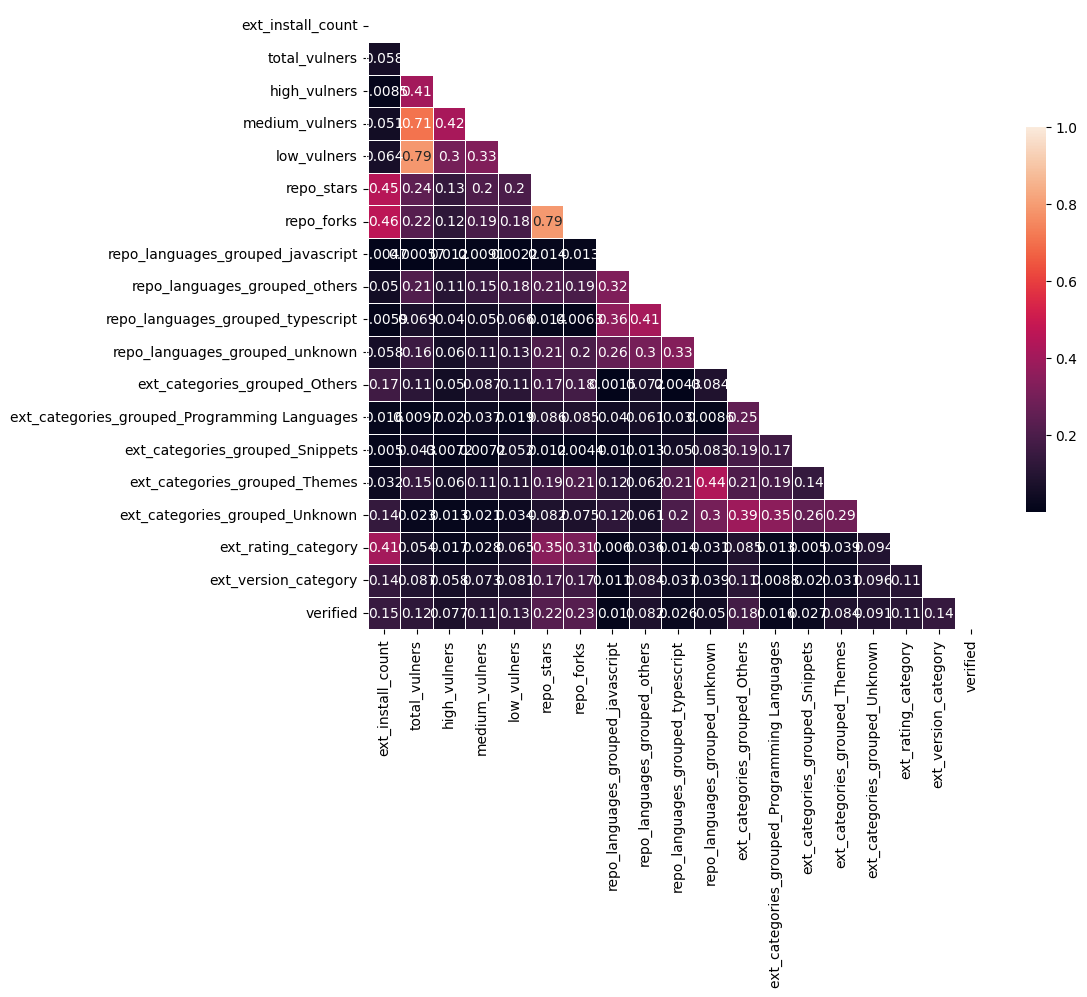

In [727]:
corr=np.abs(df_trans.corr(method="pearson"))

# Set up mask for triangle representation
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(corr, vmax=1,square=True, linewidths=.5, cbar_kws={"shrink": .5},annot = corr)
sns.heatmap(corr, mask=mask,  vmax=1,square=True, linewidths=.5, cbar_kws={"shrink": .5},annot = corr)

plt.show()

There are high correlations between **_repo stars vs repo forks, total_vulners vs low vulvers /medium vulners_**

In [729]:
df_trans= df_trans.drop("total_vulners",axis=1)

Split again the test data

In [ ]:
features_ = df_trans.drop(columns = ["verified"])
target_ = df_trans["verified"]
Xtrans_train, Xtrans_test, ytrans_train, ytrans_test = train_test_split(features,target, test_size = 0.20, random_state=0)

#### Imbalanced

In [717]:
smote = SMOTE(random_state = 1,sampling_strategy=1.0)

In [ ]:
smote_x_train, smote_y_train = smote.fit_resample(Xtrans_train, ytrans_train)

In [718]:
# def training_classification():
#     rfc = RandomForestClassifier()
#     abc = AdaBoostClassifier()
#     gbc = GradientBoostingClassifier()
#     etc = ExtraTreesClassifier()
#     lgr = LogisticRegression()
#     svc = SVC()
#     mnb = MultinomialNB()
#     xgb = XGBClassifier()
#     lgb = LGBMClassifier(verbose=-100)
#     cat = CatBoostClassifier(verbose=False)

#     models = [rfc, abc, gbc, etc, lgr,
#              svc, mnb, xgb, lgb, cat]

#     names = ["Random Forest", "Ada Boost", "Gradient Boosting", "Extra Trees", "Logistic Regression",
#             "SVC", "Naive Bayes", "XGBoost", "LightGBM", "Cat Boost"]

#     scores = []
#     cms = dict()
#     reports = dict()

#     for i, j in enumerate(names):
#         models[i].fit(x_train, y_train)
#         pred = models[i].predict(x_test)
#         scores += [accuracy_score(pred, y_test)]
#         cms[j] = confusion_matrix(pred, y_test)
#         reports[j] = classification_report(pred, y_test)

#     dt = pd.DataFrame({"scores": scores}, index=names)
#     dt = dt.sort_values("scores", ascending=False)

#     dt["scores"] = dt["scores"]*100
#     dt["scores"] = round(dt["scores"], 2)

#     fig, axes = plt.subplots(figsize=(15, 6))

#     dt["scores"].plot(kind="bar", ax=axes)
#     bar_labels(axes)

#     index = 0

#     for _ in range(2):
#         fig, axes = plt.subplots(ncols=5, figsize=(15, 6))
#         for i in range(5):
#             sns.heatmap(cms[dt.index[index]], annot=True, ax=axes[i])
#             axes[i].set_title("{}: {}%".format(dt.index[index], dt.iloc[index, 0]))
#             index += 1
#         plt.tight_layout()
#         plt.show()

#     for i in dt.index:
#         print("*"*30)
#         print("\n")
#         print(i)
#         print("\n")
#         print(reports[i])


In [719]:
# def plot_histograms_by_diagnosis(df, target='diagnosis', exclude_cols=None, bins=30, cols_per_row=3):
#     import matplotlib.pyplot as plt
#     import seaborn as sns

#     if exclude_cols is None:
#         exclude_cols = []

#     # Select only numerical columns except the target and excluded ones
#     num_cols = df.select_dtypes(include='number').columns.difference(exclude_cols + [target])
#     n = len(num_cols)
#     nrows = (n + cols_per_row - 1) // cols_per_row

#     fig, axes = plt.subplots(nrows, cols_per_row, figsize=(6 * cols_per_row, 4 * nrows))
#     axes = axes.flatten()

#     for i, col in enumerate(num_cols):
#         for diagnosis in df[target].unique():
#             sns.histplot(df[df[target] == diagnosis][col],
#                          label=str(diagnosis),
#                          bins=bins,
#                          kde=False,
#                          ax=axes[i],
#                          element='step',
#                          stat='density')

#         axes[i].set_title(f'{col} distribution by {target}', fontsize=10)
#         axes[i].legend(title=target)

#     for j in range(i + 1, len(axes)):
#         fig.delaxes(axes[j])

#     plt.tight_layout()
#     plt.show()

In [ ]:
# models = {
#     "DT":  DecisionTreeClassifier(criterion= 'entropy', max_depth= 10, max_features= None, min_samples_leaf= 4, min_samples_split= 2, splitter= 'best'),
#     "KNN": KNeighborsClassifier(n_neighbors=3,p= 1, weights= 'distance'),
#     "RF":  RandomForestClassifier( max_depth=20,max_features=7),
#     "SGD": SGDClassifier(early_stopping=True ,loss='log' ,eta0=0.001, random_state=42),
#     "XGB": XGBClassifier(learning_rate= 0.1, max_depth= 7, n_estimators=200)
# }

# MODELS_RESULTS = pd.DataFrame(
#     columns=['Model', 'Sampling By ','Train Score', 'Test Score', 'Recall', 'Precision', 'f1-score', 'classification_report'])


# def test_models(X_train, X_test, y_train, y_test, Sampling_tech):

#     for model in models:
#         # fit
#         fit = models[model].fit(X_train, y_train)
#         # sep before output
#         print('-'*40)
#         print(f' -------------------{model}-------------------')
#         print('-'*40)

#         # output
#         y_pred= fit.predict(X_test)
#         report = metrics.classification_report(y_test,y_pred)

#         print(report)
#         fig, ax = plt.subplots(figsize=(6, 4))
#         ax.set_title(model)
#         sns.heatmap(metrics.confusion_matrix(y_test, y_pred),
#                     annot=True, cmap='Blues', fmt='g', cbar=False, ax=ax)
#         plt.xlabel('Predicted labels')
#         plt.ylabel('True labels')
#         plt.show()

#         # data frame of MODELS_RESULTS and save results
#         train_score = round(fit.score(X_train, y_train), 3)
#         test_score = round(fit.score(X_test, y_test), 3)
#         recall = round(metrics.recall_score(y_test, y_pred) * 100, 2)
#         precision = round(metrics.precision_score(y_test,y_pred) * 100, 2)
#         f1 = round(metrics.f1_score(y_test, y_pred) * 100, 2)

#         MODELS_RESULTS.loc[len(MODELS_RESULTS.index)] = [model, Sampling_tech,
#                                            train_score, test_score, recall, precision, f1, report]

- 🌲 Random Forest

Ensemble of decision trees (bagging).
Uses random subsets of data and features.
Robust to overfitting and outliers.
Good baseline model for tabular data.
- ⚡ AdaBoost

Sequential boosting of weak learners.
Focuses on previous misclassified samples.
Sensitive to noise/outliers.
Good for clean data with subtle patterns.
- 🚀 XGBoost

Optimized gradient boosting algorithm.
Fast, accurate, and regularized.
Best for performance with tuning effort.

- 📊 Logistic Regression

Linear model for binary classification.
Estimates probabilities using a sigmoid function.
Assumes a linear relationship between features and the log-odds of the target.
Simple, fast, and interpretable — great baseline for linearly separable data.

- 🎯 Support Vector Machine (SVM)

Finds the optimal hyperplane that maximizes the margin between classes.
Works well in high-dimensional spaces.
Can use different kernels (linear, RBF, polynomial) to capture nonlinear patterns.
Sensitive to scaling; may be slower on large datasets.

- 👟 K-Nearest Neighbors (KNN)

Instance-based learning — no training, just storing.
Classifies based on the majority label among k-nearest neighbors.
Simple and intuitive, but slow with large datasets.
Sensitive to feature scaling and irrelevant features.